In [261]:
import pandas as pd

# Datensatz laden
file_path = 'android_traffic.csv'  # Passe den Pfad an, falls nötig
data = pd.read_csv(file_path)

# Überblick über die Daten
print("Erste 5 Zeilen des Datensatzes:")
print(data.head())

print("\nAllgemeine Informationen zum Datensatz:")
print(data.info())

print("\nStatistische Beschreibung der numerischen Daten:")
print(data.describe())

Erste 5 Zeilen des Datensatzes:
        name  tcp_packets  dist_port_tcp  external_ips  vulume_bytes  \
0  AntiVirus           36              6             3          3911   
1  AntiVirus          117              0             9         23514   
2  AntiVirus          196              0             6         24151   
3  AntiVirus            6              0             1           889   
4  AntiVirus            6              0             1           882   

   udp_packets  tcp_urg_packet  source_app_packets  remote_app_packets  \
0            0               0                  39                  33   
1            0               0                 128                 107   
2            0               0                 205                 214   
3            0               0                   7                   6   
4            0               0                   7                   6   

   source_app_bytes  remote_app_bytes  duracion  avg_local_pkt_rate  \
0              5100

In [262]:
# Fehlende Werte prüfen
missing_values = data.isnull().sum()
print("Anzahl fehlender Werte pro Spalte:")
print(missing_values)

Anzahl fehlender Werte pro Spalte:
name                       0
tcp_packets                0
dist_port_tcp              0
external_ips               0
vulume_bytes               0
udp_packets                0
tcp_urg_packet             0
source_app_packets         0
remote_app_packets         0
source_app_bytes           0
remote_app_bytes           0
duracion                7845
avg_local_pkt_rate      7845
avg_remote_pkt_rate     7845
source_app_packets.1       0
dns_query_times            0
type                       0
dtype: int64


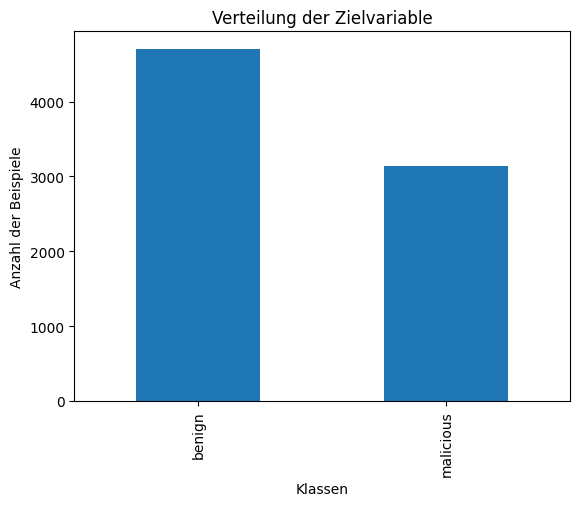

In [263]:
import matplotlib.pyplot as plt

# Zielvariable anpassen (ersetze 'target_column' durch den tatsächlichen Spaltennamen)
target_column = 'type'  # Beispiel: 'label' für Malware-Klassifikation

# Zielvariable visualisieren
data[target_column].value_counts().plot(kind='bar')
plt.title('Verteilung der Zielvariable')
plt.xlabel('Klassen')
plt.ylabel('Anzahl der Beispiele')
plt.show()

In [264]:
# Berechnung von 'duracion' mit Vermeidung von Division durch 0
data['duracion'] = data['vulume_bytes'] / (data['tcp_packets'] + data['udp_packets']).replace(0, 1)

# Fehlerhafte 'duracion'-Werte auffüllen mit Median
data['duracion'] = data['duracion'].replace([float('inf'), float('-inf')], float('nan'))  # Unendliche Werte mit NaN ersetzen
data['duracion'] = data['duracion'].fillna(data['duracion'].median())  # NaN mit Median auffüllen

# Berechnung von 'avg_local_pkt_rate' mit Vermeidung von Division durch 0
data['avg_local_pkt_rate'] = data['source_app_packets'] / data['duracion'].replace(0, 1)

# Berechnung von 'avg_remote_pkt_rate' mit Vermeidung von Division durch 0
data['avg_remote_pkt_rate'] = data['remote_app_packets'] / data['duracion'].replace(0, 1)

# Numerische Spalten auswählen
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Prüfen auf unendliche Werte und deren Vorkommen ausgeben
infinite_values = data[numeric_columns].isin([float('inf'), float('-inf')]).any()
print("Spalten mit unendlichen Werten:")
print(infinite_values)

# Spalte 'name' droppen
data = data.drop(columns=['name'], errors='ignore')

# 'type' in numerische Werte umwandeln: 0 für ungefährlich, 1 für malicious
data['type'] = data['type'].apply(lambda x: 1 if x == 'malicious' else 0)

# Überprüfen der Änderungen
print("Ersten Zeilen des bereinigten Datensatzes:")
print(data.head())

# Sicherstellen, dass die Änderungen erfolgreich sind
print("\nEinzigartige Werte in 'type':", data['type'].unique())

# Beschreibung der numerischen Daten ausgeben
data.describe()

Spalten mit unendlichen Werten:
tcp_packets             False
dist_port_tcp           False
external_ips            False
vulume_bytes            False
udp_packets             False
tcp_urg_packet          False
source_app_packets      False
remote_app_packets      False
source_app_bytes        False
remote_app_bytes        False
duracion                False
avg_local_pkt_rate      False
avg_remote_pkt_rate     False
source_app_packets.1    False
dns_query_times         False
dtype: bool
Ersten Zeilen des bereinigten Datensatzes:
   tcp_packets  dist_port_tcp  external_ips  vulume_bytes  udp_packets  \
0           36              6             3          3911            0   
1          117              0             9         23514            0   
2          196              0             6         24151            0   
3            6              0             1           889            0   
4            6              0             1           882            0   

   tcp_urg_packet 

,tcp_packets,dist_port_tcp,external_ips,vulume_bytes,udp_packets,tcp_urg_packet,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,duracion,avg_local_pkt_rate,avg_remote_pkt_rate,source_app_packets.1,dns_query_times,type
count,7845.00,7845.00,7845.00,7845.00,7845.00,7845.00,7845.00,7845.00,7845.00,7845.00,7845.00,7845.00,7845.00,7845.00,7845.00,7845.00
mean,147.58,7.74,2.75,16543.75,0.06,0.00,152.91,194.71,202496.72,16922.60,148.00,1.85,4.04,152.91,4.90,0.40
std,777.92,51.65,2.92,82256.50,1.39,0.02,779.03,1068.11,1401075.62,82381.82,215.23,9.72,71.66,779.03,18.90,0.49
min,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,69.00,0.00,0.00,0.00,1.00,0.00,0.00
25%,6.00,0.00,1.00,888.00,0.00,0.00,7.00,7.00,934.00,1046.00,78.13,0.12,0.08,7.00,1.00,0.00
50%,25.00,0.00,2.00,3509.00,0.00,0.00,30.00,24.00,4090.00,3803.00,122.72,0.38,0.32,30.00,3.00,0.00
75%,93.00,0.00,4.00,12189.00,0.00,0.00,98.00,92.00,26244.00,12610.00,167.72,1.07,1.36,98.00,5.00,1.00
max,37143.00,2167.00,43.00,4226790.00,65.00,1.00,37150.00,45928.00,68235164.00,4227323.00,3672.00,403.45,6153.00,37150.00,913.00,1.00


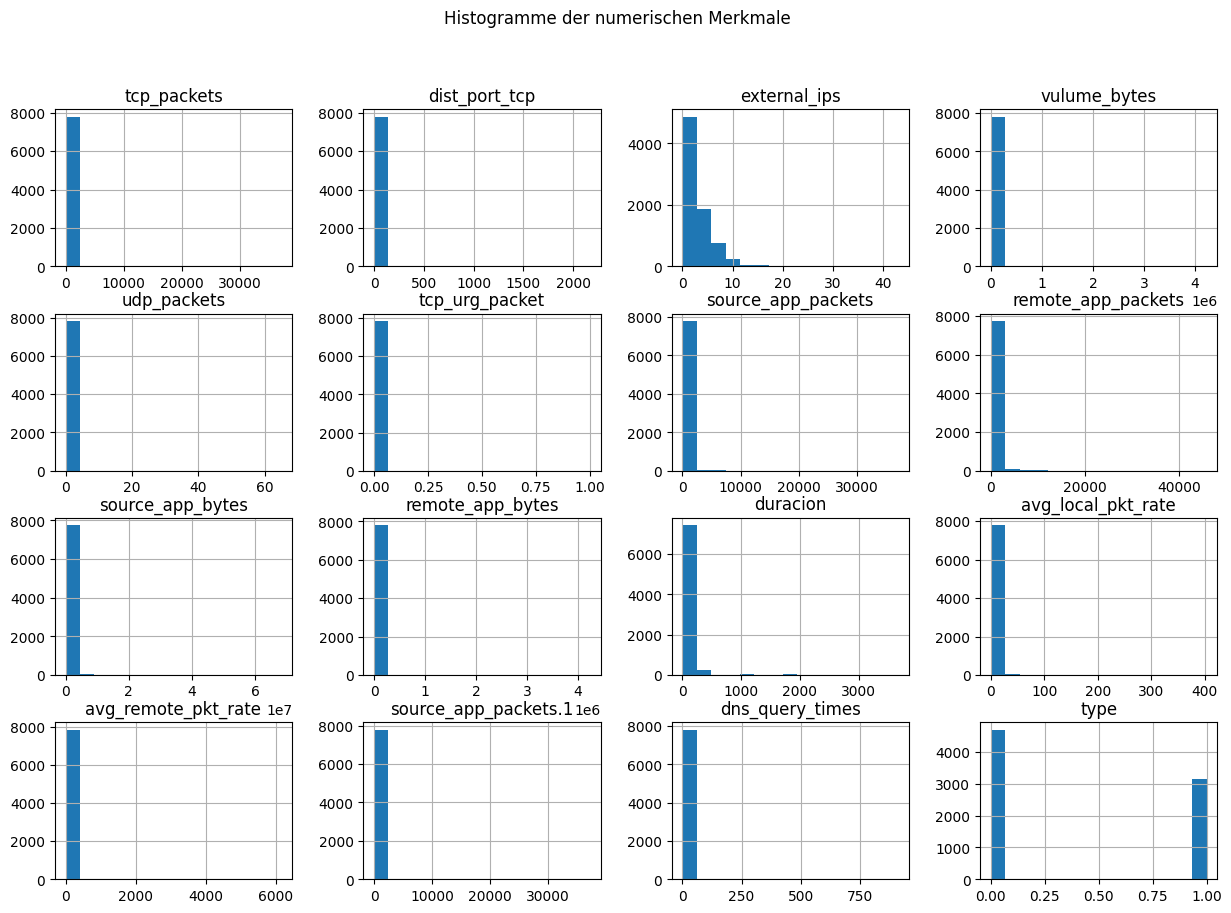

In [265]:
# Numerische Spalten auswählen
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Histogramme erstellen
data[numeric_columns].hist(bins=15, figsize=(15, 10))
plt.suptitle('Histogramme der numerischen Merkmale')
plt.show()

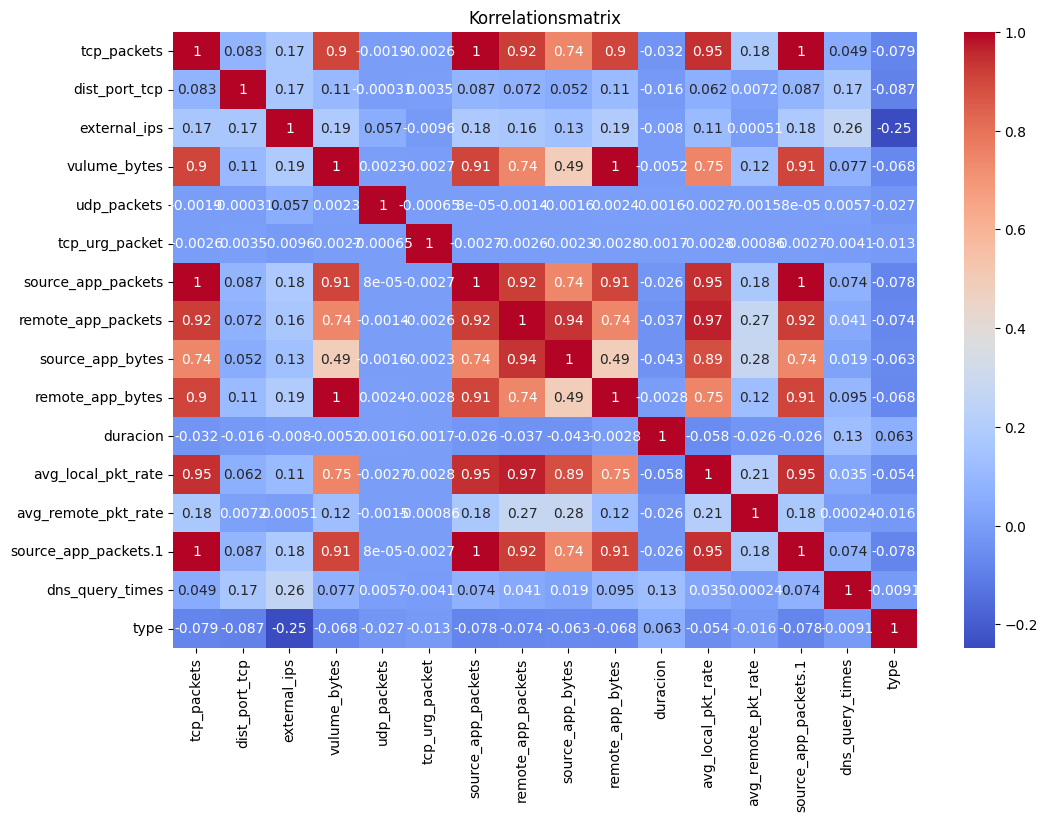

In [266]:
import seaborn as sns
import matplotlib.pyplot as plt

# Korrelationsmatrix berechnen, ohne 'type' und 'name'
correlation_matrix = data.corr()

# Heatmap plotten
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Korrelationsmatrix')
plt.show()

In [267]:
# Zielvariable und Features definieren
X = data.drop(columns=['type'])  # 'type' als Zielvariable entfernen
y = data['type']  # 'type' als Zielvariable

# Überprüfen der Shapes
print("Shape von X (Features):", X.shape)
print("Shape von y (Zielvariable):", y.shape)

Shape von X (Features): (7845, 15)
Shape von y (Zielvariable): (7845,)


In [268]:
from sklearn.model_selection import train_test_split

# Daten in Trainings- und Testdaten aufteilen
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Überprüfen der Shapes
print("Shape von X_train:", X_train.shape)
print("Shape von X_test:", X_test.shape)
print("Shape von y_train:", y_train.shape)
print("Shape von y_test:", y_test.shape)

Shape von X_train: (6276, 15)
Shape von X_test: (1569, 15)
Shape von y_train: (6276,)
Shape von y_test: (1569,)


In [269]:
from sklearn.preprocessing import StandardScaler

# Standardisierung der Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Überprüfen, ob die Standardisierung funktioniert hat
print("Erste Zeilen von X_train nach der Standardisierung:")
print(X_train[:5])

Erste Zeilen von X_train nach der Standardisierung:
[[-0.17553082  0.10650237  0.43375319 -0.18269174 -0.04186326 -0.0178543
  -0.179674   -0.19219682 -0.16008755 -0.18503521 -0.34481462 -0.18246928
  -0.19700277 -0.179674   -0.14488537]
 [ 0.6583353  -0.16283633 -0.25989824  0.44166812 -0.04186326 -0.0178543
   0.65417774  0.83587214  0.97465138  0.43904664 -0.29882931  0.66655306
   0.54208721  0.65417774 -0.09506614]
 [-0.16623613  0.26361661 -0.60672395 -0.17705311 -0.04186326 -0.0178543
  -0.17171993 -0.17477193 -0.14434138 -0.1803394  -0.3552488  -0.17233389
  -0.18233492 -0.17171993 -0.1947046 ]
 [-0.19146456 -0.16283633 -0.95354967 -0.19321087 -0.04186326 -0.0178543
  -0.19425646 -0.19117183 -0.16004809 -0.19459243 -0.6941112   0.13618433
  -0.01349872 -0.19425646 -0.09506614]
 [-0.16092488 -0.16283633 -0.60672395 -0.14679878 -0.04186326 -0.0178543
  -0.16509154 -0.17682191 -0.15868679 -0.14937305  0.10996871 -0.18727952
  -0.19251119 -0.16509154 -0.14488537]]


In [270]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Modell erstellen und trainieren
model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Vorhersagen auf Testdaten
y_pred = model.predict(X_test)

# Modell bewerten
print("Klassifikationsbericht:")
print(classification_report(y_test, y_pred))

print("Konfusionsmatrix:")
print(confusion_matrix(y_test, y_pred))

Klassifikationsbericht:
              precision    recall  f1-score   support

           0       0.74      0.54      0.62       938
           1       0.51      0.71      0.60       631

    accuracy                           0.61      1569
   macro avg       0.62      0.63      0.61      1569
weighted avg       0.65      0.61      0.61      1569

Konfusionsmatrix:
[[507 431]
 [180 451]]


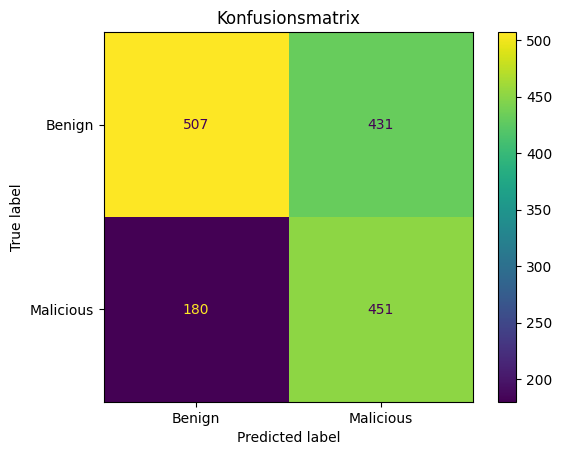

In [271]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Konfusionsmatrix plotten
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Benign", "Malicious"])
plt.title("Konfusionsmatrix")
plt.show()

In [272]:
from sklearn.metrics import precision_recall_curve

# Vorhersagewahrscheinlichkeiten
y_proba = model.predict_proba(X_test)[:, 1]

# Schwellenwertoptimierung basierend auf Precision-Recall
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Optimalen Schwellenwert finden
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_threshold = thresholds[np.argmax(f1_scores)]
print("Optimaler Schwellenwert basierend auf F1-Score:", optimal_threshold)

# Neue Vorhersagen mit optimiertem Schwellenwert
y_pred_thresholded = (y_proba >= optimal_threshold).astype(int)

# Klassifikationsbericht und Konfusionsmatrix mit neuem Schwellenwert
print("Klassifikationsbericht mit optimiertem Schwellenwert:")
print(classification_report(y_test, y_pred_thresholded))

print("Konfusionsmatrix mit optimiertem Schwellenwert:")
print(confusion_matrix(y_test, y_pred_thresholded))

Optimaler Schwellenwert basierend auf F1-Score: 0.9999348204519508
Klassifikationsbericht mit optimiertem Schwellenwert:
              precision    recall  f1-score   support

           0       0.60      1.00      0.75       938
           1       0.00      0.00      0.00       631

    accuracy                           0.60      1569
   macro avg       0.30      0.50      0.37      1569
weighted avg       0.36      0.60      0.45      1569

Konfusionsmatrix mit optimiertem Schwellenwert:
[[937   1]
 [631   0]]


/var/folders/7g/s84zkf0s2nv6td4tsl9bwh3m0000gn/T/ipykernel_48252/955944312.py:10: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [273]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest Modell erstellen
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

# Vorhersagen auf Testdaten
y_pred_rf = rf_model.predict(X_test)

# Modell bewerten
print("Klassifikationsbericht (Random Forest):")
print(classification_report(y_test, y_pred_rf))

print("Konfusionsmatrix (Random Forest):")
print(confusion_matrix(y_test, y_pred_rf))

Klassifikationsbericht (Random Forest):
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       938
           1       0.90      0.88      0.89       631

    accuracy                           0.91      1569
   macro avg       0.91      0.91      0.91      1569
weighted avg       0.91      0.91      0.91      1569

Konfusionsmatrix (Random Forest):
[[876  62]
 [ 76 555]]


In [274]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=42),
                           param_grid, scoring='f1_macro', cv=3)
grid_search.fit(X_train, y_train)

print("Beste Parameter:", grid_search.best_params_)
best_rf_model = grid_search.best_estimator_

KeyboardInterrupt: 

In [293]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Fortschrittsanzeige für das Training
print("Training des Random Forest Modells...")
for _ in tqdm(range(1)):  # tqdm simuliert hier den Fortschritt (da RF intern arbeitet)
    optimized_rf_model = RandomForestClassifier(
        max_depth=20,
        min_samples_leaf=1,
        min_samples_split=2,
        n_estimators=100,
        class_weight='balanced',
        random_state=42
    )
    optimized_rf_model.fit(X_train, y_train)

# Vorhersagen auf Testdaten
print("Vorhersagen berechnen...")
y_pred_optimized_rf = optimized_rf_model.predict(X_test)

# Modell bewerten
print("Klassifikationsbericht (Optimiertes Random Forest):")
print(classification_report(y_test, y_pred_optimized_rf))

print("Konfusionsmatrix (Optimiertes Random Forest):")
print(confusion_matrix(y_test, y_pred_optimized_rf))

Training des Random Forest Modells...


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

Vorhersagen berechnen...
Klassifikationsbericht (Optimiertes Random Forest):
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       938
           1       0.89      0.88      0.89       631

    accuracy                           0.91      1569
   macro avg       0.91      0.90      0.91      1569
weighted avg       0.91      0.91      0.91      1569

Konfusionsmatrix (Optimiertes Random Forest):
[[873  65]
 [ 77 554]]


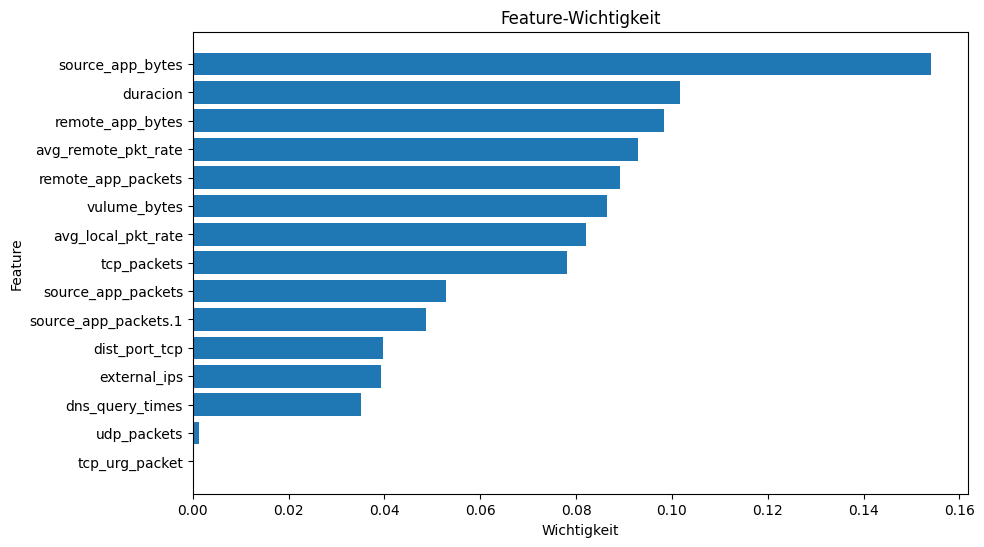

In [294]:
# Feature-Importanz plotten
import matplotlib.pyplot as plt
import pandas as pd

# Spaltennamen aus ursprünglichem DataFrame
feature_names = data.drop(columns=['type']).columns

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Wichtigkeit')
plt.ylabel('Feature')
plt.title('Feature-Wichtigkeit')
plt.gca().invert_yaxis()
plt.show()

In [295]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(optimized_rf_model, X, y, cv=5, scoring='f1_macro')
print("Durchschnittlicher F1-Score aus Cross-Validation:", cv_scores.mean())

Durchschnittlicher F1-Score aus Cross-Validation: 0.7718268513685399


In [303]:
import joblib

# Speichern des Modells
joblib.dump(optimized_rf_model, 'optimized_rf_model.pkl')
print("Modell gespeichert!")

Modell gespeichert!
